# Team Topic Thunder
### CS 410, Fall 2021

# Topic Model Evaluation

Mine topics of CS 410 course projects for a range of k = number of topics.

Next, generate a model with optimal k, and use the pyLDAvis library to visualize topic coverage and overlap.

Finally, output results:
* The dominant topic for each CS 410 project
* The most representative project documentation for each topic
* The optimal model
* The dictionary and corpus
* Final output for the [Topic Thunder web app](https://topic-thunder-a7103.web.app/) to consume

## Step 1: Import Packages and Cleaned Text

Note that this doesn't include code for text preprocessing. That's done as a separate step in `text_cleaning.py`.

### Ignore deprecation warnings and import required packages

In [1]:
import pandas as pd
from ast import literal_eval #to convert file from a string as we are reading from .tsv

import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this

from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\ktuoh\anaconda3\envs\py388\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Ignore deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\ktuoh\anaconda3\envs\py388\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Import cleaned project text, and build a dictionary and document-term matrix

In [3]:
# Import cleaned text
df=pd.read_csv('../project_clean_text.tsv',sep='\t',converters={'clean_text': literal_eval})
df.head()

,project_url,file_text,clean_text
0,https://github.com/17JamesH/CourseProject,project progress report team member task progr...,"[remaining, risk, james, crawling, redfin, wor..."
1,https://github.com/97agupta/CourseProject,team 'buddie' project proposal 1. what are the...,"[buddie, proposal, netids, administrative, dut..."
2,https://github.com/AShipway/CourseProject,aaron shipway cs 410 fall '21 project progress...,"[aaron, shipway, fall, completed, established,..."
3,https://github.com/AlexZurski/CourseProject,alexander zurawski azuraws2 cs 410 11/15/2021 ...,"[alexander, zurawski, azuraws, final, complete..."
4,https://github.com/AnantSharma18/CourseProject,page 1 of 2 project progress report anant ashu...,"[anant, ashutosh, sharma, anantas, edu, indivi..."


In [4]:
#Creating a mega list of each mega document's cleaned up tokens
megalist=[]
for i in range (len(df)):
    megalist.append(df['clean_text'][i])

In [5]:
# creating a dictionary from the list of lists
dictionary=corpora.Dictionary(megalist)

In [6]:
# Term Document Frequency
doc_term_matrix = [dictionary.doc2bow(doc, allow_update=True) for doc in megalist]

## Step 2: Generate models for range of k = number of topics

Also compute perplexity and coherence scores for each model.

Code copied and adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [7]:
# Routine to generate and score models for a range of k.

def generate_and_score_models(dictionary, corpus, texts, limit, start=2, step=2, random_state=100, alpha="auto"):
    """
   Generate topic models for a range of topic counts.
   Evaluate coherence for each topic count, and return lists.

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    perplexity_values: The log of the perplexity of the corresponding LDA model.
    """
    model_list = []
    coherence_values = []
    log_perplexity_values = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics, 
                         random_state=random_state,  # For repeatability
                         passes=10,
                         iterations=50,
                         alpha=alpha)  # Use "auto" to learn the document-topic distribution
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        log_perplexity_values.append(model.log_perplexity(corpus))

    return model_list, coherence_values, log_perplexity_values

In [8]:
# Generate models for the given range of k

start = 2
step = 2
limit = 40

model_list, coherence_values, log_perplexity_values = generate_and_score_models(dictionary=dictionary,
                                                                                corpus=doc_term_matrix,
                                                                                texts=megalist,
                                                                                limit=limit,
                                                                                start=start,
                                                                                step=step,
                                                                                random_state=100,
                                                                                alpha="auto")

## Step 3: Review Results

### Review coherence scores

Topic coherence is partly based on the conditional likelihood of co-occurrence of words in a topic. Coherence helps to measure how well-related a topic's words are to each other. For more, see the article [Topic Model Evaluation](https://highdemandskills.com/topic-model-evaluation).

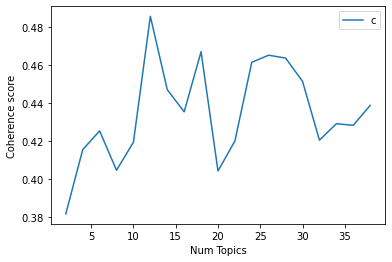

In [9]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [10]:
for k, cv in zip(x, coherence_values):
    print("Num Topics =", k, "has Coherence Value of", round(cv, 4))

Num Topics = 2 has Coherence Value of 0.3818
Num Topics = 4 has Coherence Value of 0.4156
Num Topics = 6 has Coherence Value of 0.4254
Num Topics = 8 has Coherence Value of 0.4048
Num Topics = 10 has Coherence Value of 0.4195
Num Topics = 12 has Coherence Value of 0.4857
Num Topics = 14 has Coherence Value of 0.4471
Num Topics = 16 has Coherence Value of 0.4355
Num Topics = 18 has Coherence Value of 0.4671
Num Topics = 20 has Coherence Value of 0.4044
Num Topics = 22 has Coherence Value of 0.4201
Num Topics = 24 has Coherence Value of 0.4615
Num Topics = 26 has Coherence Value of 0.4652
Num Topics = 28 has Coherence Value of 0.4637
Num Topics = 30 has Coherence Value of 0.4515
Num Topics = 32 has Coherence Value of 0.4206
Num Topics = 34 has Coherence Value of 0.4292
Num Topics = 36 has Coherence Value of 0.4284
Num Topics = 38 has Coherence Value of 0.4388


Coherence rises to a local peak at 6 topics, then hits a higher peak at 12 topics.

It's common practice to pick the first model that hits peak coherence before plateauing. These coherence scores don't form a plateau, however, which may reflect topic instability.

### Review log-perplexity scores

Topic perplexity is proportional to the inverse probability of a test set against the topics mined from a training set. Perplexity is computed from held-out data. A lower perplexity reflects a better topic model. For more, see the article [Perplexity in Language Models](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94).

However, the article [Topic Model Evaluation](https://highdemandskills.com/topic-model-evaluation) suggests that models with better perplexity scores are harder for humans to interpret.

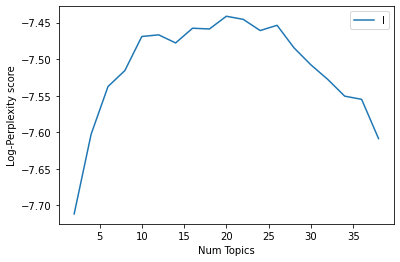

In [11]:
x = range(start, limit, step)
plt.plot(x, log_perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Log-Perplexity score")
plt.legend(("log_perplexity_values"), loc='best')
plt.show()

In [12]:
for k, lpv in zip(x, log_perplexity_values):
    print("Num Topics =", k, "has Log-Perplexity Value of", round(lpv, 4))

Num Topics = 2 has Log-Perplexity Value of -7.7247
Num Topics = 4 has Log-Perplexity Value of -7.6174
Num Topics = 6 has Log-Perplexity Value of -7.5992
Num Topics = 8 has Log-Perplexity Value of -7.5604
Num Topics = 10 has Log-Perplexity Value of -7.5147
Num Topics = 12 has Log-Perplexity Value of -7.4659
Num Topics = 14 has Log-Perplexity Value of -7.4454
Num Topics = 16 has Log-Perplexity Value of -7.479
Num Topics = 18 has Log-Perplexity Value of -7.4696
Num Topics = 20 has Log-Perplexity Value of -7.4633
Num Topics = 22 has Log-Perplexity Value of -7.4722
Num Topics = 24 has Log-Perplexity Value of -7.4761
Num Topics = 26 has Log-Perplexity Value of -7.4989
Num Topics = 28 has Log-Perplexity Value of -7.543
Num Topics = 30 has Log-Perplexity Value of -7.5516
Num Topics = 32 has Log-Perplexity Value of -7.5821
Num Topics = 34 has Log-Perplexity Value of -7.618
Num Topics = 36 has Log-Perplexity Value of -7.6179
Num Topics = 38 has Log-Perplexity Value of -7.6587


As we're aiming for low log-perplexity, the only options seem to be models with 4 or fewer topics, or 34 or more.

### Examine highlighted topic models

Review the 12-topic model highlighted by the coherence scores.

Additionally, examine the 6-topic model, which hits a local peak of coherence and shows relatively low perplexity.

Finally, look at 8- and 10-topic models in case pyLDAvis shows largely overlapping topics for the larger model.

View the topics themselves, and generate pyLDAvis breakdowns to help gauge topic sizes and degrees of overlap.

In pyLDAvis, overlap or close proximity of topics indicates high similarity. Generally, we should look for models with well-separated topics. For more information, see [pyLDAvis: Topic Modelling Exploration Tool That Every NLP Data Scientist Should Know](https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know).

#### 6-topic model

* 0: Topic modeling; system extension; possible scraping of faculty homepages
* 1: Sentiment analysis, possibly involving stock-related tweets; possible time-series supervision
* 2: Twitter sarcasm detection; time series
* 3: Frequent pattern mining; contextual text mining; document clustering
* 4: Text classification using BERT; contextual text mining; competition-centered CS 410 projects
* 5: Topic modeling; Twitter and book-related data

In [12]:
# Show topics for the 6-topic model
pprint(model_list[2].print_topics(num_words=10))

[(0,
  '0.014*"topic" + 0.013*"search" + 0.010*"system" + 0.008*"url" + '
  '0.008*"faculty" + 0.007*"text" + 0.006*"model" + 0.006*"extension" + '
  '0.006*"document" + 0.006*"time"'),
 (1,
  '0.019*"sentiment" + 0.010*"analysis" + 0.008*"stock" + 0.007*"model" + '
  '0.007*"rating" + 0.006*"tweet" + 0.006*"topic" + 0.006*"document" + '
  '0.005*"time" + 0.005*"api"'),
 (2,
  '0.098*"twitter" + 0.060*"sarcasm" + 0.036*"not_sarcasm" + 0.025*"topic" + '
  '0.012*"time" + 0.009*"model" + 0.007*"series" + 0.007*"document" + '
  '0.006*"algorithm" + 0.005*"text"'),
 (3,
  '0.020*"model" + 0.015*"pattern" + 0.011*"text" + 0.010*"collection" + '
  '0.009*"context" + 0.007*"topic" + 0.007*"mining" + 0.006*"document" + '
  '0.006*"frequent" + 0.006*"cluster"'),
 (4,
  '0.038*"model" + 0.016*"bert" + 0.012*"text" + 0.011*"classification" + '
  '0.008*"context" + 0.008*"learning" + 0.007*"response" + 0.007*"competition" '
  '+ 0.007*"sarcasm" + 0.006*"network"'),
 (5,
  '0.019*"model" + 0.015*"t

pyLDAvis output for the 6-topic model.

Topics 2 (Twitter sarcasm detection), 4 (text classification) and 5 (topic modeling) show good separation from others. The remaining topics show slight overlap, but much less than in models with more topics.

Do overlapping topics share some of the same subtopics?

In [13]:
pyLDAvis.enable_notebook()
vis_6_topics = pyLDAvis.gensim_models.prepare(model_list[2], doc_term_matrix, dictionary=model_list[2].id2word)
vis_6_topics

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.077831 -0.073622       1        1  28.534584
3     -0.006911 -0.083836       2        1  18.490122
4     -0.020837  0.149139       3        1  17.772734
1     -0.045057 -0.030663       4        1  16.005836
2      0.186101 -0.014447       5        1  11.382678
5     -0.035465  0.053429       6        1   7.814046, topic_info=             Term         Freq        Total Category  logprob  loglift
1033      twitter  3776.000000  3776.000000  Default  30.0000  30.0000
1733      sarcasm  2410.000000  2410.000000  Default  29.0000  29.0000
1707  not_sarcasm  1287.000000  1287.000000  Default  28.0000  28.0000
358         model  4667.000000  4667.000000  Default  27.0000  27.0000
2280      pattern   814.000000   814.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
31         create    61.164689   735.612998   Topic6  -5.9266   0.0621
710        system    68.581558  1344.046385   Topic6  -5.8122  -0.4262
987     sentiment    62.492537  1137.407953   Topic6  -5.9051  -0.3522
97            one    58.133129   956.487203   Topic6  -5.9774  -0.2513
207     completed    55.676090   595.311064   Topic6  -6.0206   0.1797

[477 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
13195      1  0.973177  _________
8607       4  0.970081    _player
5652       3  0.939590   abhishek
8902       5  0.949743   abortion
11097      6  0.910985        acc
...      ...       ...        ...
531        1  0.009232       york
531        2  0.175409       york
531        4  0.055392       york
531        5  0.747796       york
531        6  0.009232       york

[1350 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 2, 3, 6])

_Screenshot of pyLDAvis output for 6-topic model_
![Screenshot of pyLDAvis output for 6-topic model](6_topic_model_pyLDAvis_overall.png)

#### 8-topic model

* 0: Topic modeling; system extension; possible scraping of faculty homepages
* 1: MeTA/MetaPy; topic modeling; aspect mining; ranking of results
* 2: Twitter sarcasm detection; time series
* 3: Frequent-pattern mining; contextual text mining; topic modeling; text clustering
* 4: Text classification using BERT and neural networks; contextual text mining; competition-centered CS 410 projects; some sarcasm detection
* 5: Topic modeling; Twitter; sentiment analysis
* 6: Sentiment analysis, possibly related to stock prices over time
* 7: Sentiment analysis; text classification; news- or music-related data

In [16]:
# Show topics for the 8-topic model
pprint(model_list[3].print_topics(num_words=10))

[(0,
  '0.015*"topic" + 0.013*"search" + 0.011*"system" + 0.009*"faculty" + '
  '0.009*"url" + 0.007*"text" + 0.007*"extension" + 0.007*"model" + '
  '0.006*"document" + 0.006*"time"'),
 (1,
  '0.012*"model" + 0.010*"metapy" + 0.009*"meta" + 0.009*"document" + '
  '0.008*"topic" + 0.006*"analysis" + 0.006*"ranking" + 0.006*"aspect" + '
  '0.006*"output" + 0.005*"text"'),
 (2,
  '0.102*"twitter" + 0.062*"sarcasm" + 0.037*"not_sarcasm" + 0.025*"topic" + '
  '0.012*"time" + 0.009*"model" + 0.008*"series" + 0.007*"document" + '
  '0.006*"text" + 0.006*"algorithm"'),
 (3,
  '0.021*"model" + 0.017*"pattern" + 0.011*"collection" + 0.010*"text" + '
  '0.010*"context" + 0.007*"mining" + 0.007*"frequent" + 0.006*"topic" + '
  '0.006*"cluster" + 0.005*"document"'),
 (4,
  '0.042*"model" + 0.017*"bert" + 0.012*"classification" + 0.012*"text" + '
  '0.009*"context" + 0.009*"response" + 0.009*"sarcasm" + 0.008*"learning" + '
  '0.008*"competition" + 0.007*"neural"'),
 (5,
  '0.018*"model" + 0.012*"t

pyLDAvis output for the 8-topic model.

pyLDAvis shows 4 topics with decent separation, while other topics appear in overlapping pairs. This may indicate only 6 real topics.

Topics with separation are 2, 3, 4 and 7 (above).

The two pairs of topics are 0 + 6 and 1 + 5.

In [17]:
vis_8_topics = pyLDAvis.gensim_models.prepare(model_list[3], doc_term_matrix, dictionary=model_list[3].id2word)
vis_8_topics

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.086941  0.040209       1        1  24.988771
3     -0.010822  0.056612       2        1  16.431146
4     -0.073081 -0.165077       3        1  14.733501
2     -0.173305  0.100163       4        1  11.262057
7      0.015013 -0.058238       5        1  10.448182
6      0.087145  0.045366       6        1   8.698821
1      0.041560 -0.010806       7        1   8.103209
5      0.026549 -0.008230       8        1   5.334313, topic_info=             Term         Freq        Total Category  logprob  loglift
1033      twitter  3841.000000  3841.000000  Default  30.0000  30.0000
1733      sarcasm  2457.000000  2457.000000  Default  29.0000  29.0000
1707  not_sarcasm  1314.000000  1314.000000  Default  28.0000  28.0000
358         model  4703.000000  4703.000000  Default  27.0000  27.0000
2280      pattern   827.000000   827.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
642      expected    38.281987   365.669665   Topic8  -6.0134   0.6743
832       feature    41.011335   596.998963   Topic8  -5.9446   0.2529
62            get    40.474875   585.356722   Topic8  -5.9577   0.2595
227      datasets    39.287709   537.169799   Topic8  -5.9875   0.3156
74    information    41.195020  1054.260613   Topic8  -5.9401  -0.3113

[631 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
13195      1  0.986185  _________
8607       6  0.952695    _player
5652       3  0.928992   abhishek
8902       4  0.932104   abortion
11097      8  0.927652        acc
...      ...       ...        ...
531        4  0.690064       york
531        5  0.036319       york
531        6  0.054479       york
531        7  0.027239       york
531        8  0.018160       york

[2020 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 3, 8, 7, 2, 6])

_Screenshot of pyLDAvis output for 8-topic model_
![Screenshot of pyLDAvis output for 8-topic model](8_topic_model_pyLDAvis_overall.png)

#### 10-topic model

In [18]:
# Model with 10 topics
pprint(model_list[4].print_topics(num_words=10))

[(0,
  '0.016*"topic" + 0.014*"system" + 0.014*"search" + 0.013*"faculty" + '
  '0.013*"url" + 0.008*"model" + 0.007*"text" + 0.006*"directory" + '
  '0.005*"document" + 0.005*"time"'),
 (1,
  '0.014*"aspect" + 0.013*"meta" + 0.011*"topic" + 0.009*"metapy" + '
  '0.009*"rating" + 0.008*"model" + 0.007*"analysis" + 0.005*"system" + '
  '0.005*"positive" + 0.004*"patient"'),
 (2,
  '0.197*"twitter" + 0.121*"sarcasm" + 0.073*"not_sarcasm" + 0.015*"slide" + '
  '0.011*"model" + 0.008*"document" + 0.005*"educationalweb" + 0.004*"bert" + '
  '0.004*"text" + 0.003*"evaluation"'),
 (3,
  '0.021*"model" + 0.018*"pattern" + 0.012*"collection" + 0.011*"context" + '
  '0.010*"text" + 0.008*"mining" + 0.007*"frequent" + 0.007*"cluster" + '
  '0.006*"document" + 0.005*"topic"'),
 (4,
  '0.044*"model" + 0.020*"bert" + 0.014*"classification" + 0.014*"text" + '
  '0.012*"context" + 0.011*"response" + 0.010*"learning" + 0.010*"sarcasm" + '
  '0.009*"competition" + 0.008*"neural"'),
 (5,
  '0.033*"model"

pyLDAvis output for 10 topics.

Topics 2, 4, 5 and 7 show reasonable separation from others. The other 6 topics inhabit a single cluster.

In [19]:
vis_10_topics = pyLDAvis.gensim_models.prepare(model_list[4], doc_term_matrix, dictionary=model_list[4].id2word)
vis_10_topics

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.054851  0.020442       1        1  19.519283
0      0.072551  0.029142       2        1  16.736732
3      0.060498  0.005007       3        1  15.341682
4     -0.112246 -0.135450       4        1  11.781169
7     -0.014244 -0.085157       5        1   8.243051
9      0.076246  0.032199       6        1   8.190735
1      0.094105  0.032209       7        1   5.438888
2     -0.224264  0.159526       8        1   5.258590
6      0.055269  0.056756       9        1   4.809995
5     -0.062766 -0.114675      10        1   4.679875, topic_info=             Term         Freq        Total Category  logprob  loglift
1033      twitter  3565.000000  3565.000000  Default  30.0000  30.0000
1733      sarcasm  2268.000000  2268.000000  Default  29.0000  29.0000
1707  not_sarcasm  1198.000000  1198.000000  Default  28.0000  28.0000
358         model  4700.000000  4700.000000  Default  27.0000  27.0000
138         topic  2848.000000  2848.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
892          like    40.451900   565.143964  Topic10  -5.8274   0.4249
1733      sarcasm    46.143197  2268.850903  Topic10  -5.6958  -0.8334
515         value    38.499340   437.243711  Topic10  -5.8769   0.6320
713          term    38.181808   496.421374  Topic10  -5.8852   0.4968
1033      twitter    39.893630  3565.892658  Topic10  -5.8413  -1.4311

[757 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
13195      2  0.970709  _________
8607       1  0.960997    _player
8902       6  0.926409   abortion
11097     10  0.912377        acc
735        1  0.179817   accuracy
...      ...       ...        ...
531        6  0.725383       york
531        9  0.045336       york
531       10  0.009067       york
15403      8  0.853683     zainal
15404      8  0.853639    zainalh

[2605 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 4, 5, 8, 10, 2, 3, 7, 6])

_Screenshot of pyLDAvis output for 10-topic model_
![Screenshot of pyLDAvis output for 10-topic model](10_topic_model_pyLDAvis_overall.png)

#### 12-topic model

This has the highest coherence score in the coherence chart.

Topics:
* 0: Search or collection of faculty homepages
* 1: Topic modeling; aspect mining; ratings, possibly related to recipes
* 2: Possible extension of EducationalWeb system
* 3: Frequent-pattern mining; contextual text mining; text clustering
* 4: Twitter sarcasm detection
* 5: Text analysis using BERT or neural networks
  * Focuses on methodology rather than project topics
* 6: Sentiment analysis using stock-market data or tweets
* 7: Text classification using BERT or neural networks; competition-centered projects
* 8: Topic modeling; sentiment analysis; system extension
* 9: Causal topic modeling with time series supervision
* 10: Sentiment analysis; topic modeling; Twitter; possible time series supervision
* 11: MeTA/MetaPy; with possible project code installation instructions

In [14]:
# Model with 12 topics
pprint(model_list[5].print_topics(num_words=10))

[(0,
  '0.017*"topic" + 0.015*"search" + 0.015*"faculty" + 0.014*"url" + '
  '0.012*"system" + 0.009*"model" + 0.007*"text" + 0.007*"document" + '
  '0.007*"directory" + 0.005*"time"'),
 (1,
  '0.017*"topic" + 0.014*"aspect" + 0.010*"analysis" + 0.010*"rating" + '
  '0.010*"recipe" + 0.010*"model" + 0.008*"positive" + 0.007*"patient" + '
  '0.006*"pkl" + 0.006*"deid"'),
 (2,
  '0.018*"slide" + 0.013*"document" + 0.012*"system" + 0.009*"lecture" + '
  '0.008*"topic" + 0.007*"model" + 0.007*"text" + 0.006*"book" + '
  '0.006*"educationalweb" + 0.006*"algorithm"'),
 (3,
  '0.022*"model" + 0.018*"pattern" + 0.012*"collection" + 0.011*"context" + '
  '0.011*"text" + 0.008*"mining" + 0.007*"frequent" + 0.006*"cluster" + '
  '0.006*"document" + 0.006*"topic"'),
 (4,
  '0.247*"twitter" + 0.158*"sarcasm" + 0.089*"not_sarcasm" + 0.020*"model" + '
  '0.010*"bert" + 0.008*"response" + 0.006*"context" + 0.005*"learning" + '
  '0.004*"tweet" + 0.004*"colab"'),
 (5,
  '0.036*"model" + 0.008*"lstm" + 

pyLDAvis output for 12 topics

Topics 4 (Twitter sarcasm detection) and 11 (MeTA/MetaPy) have separation from other models. Remaining topics have high overlap in a total of three clusters.

In [15]:
vis_12_topics = pyLDAvis.gensim_models.prepare(model_list[5], doc_term_matrix, dictionary=model_list[5].id2word)
vis_12_topics

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.076016 -0.052648       1        1  17.450559
3      0.039171 -0.123739       2        1  14.879292
0      0.086370  0.046717       3        1  14.772102
8      0.046775  0.011249       4        1  14.085497
9      0.034670 -0.094510       5        1   7.431619
2      0.056708  0.009853       6        1   6.691449
5     -0.087398 -0.042910       7        1   4.798794
10     0.056699 -0.025482       8        1   4.743952
4     -0.335498  0.061701       9        1   4.489512
6      0.037585  0.051794      10        1   3.927276
11     0.094825  0.167628      11        1   3.452422
1      0.046108 -0.009654      12        1   3.277526, topic_info=             Term         Freq        Total Category  logprob  loglift
1033      twitter  3569.000000  3569.000000  Default  30.0000  30.0000
1733      sarcasm  2256.000000  2256.000000  Default  29.0000  29.0000
1707  not_sarcasm  1207.000000  1207.000000  Default  28.0000  28.0000
138         topic  2801.000000  2801.000000  Default  27.0000  27.0000
358         model  4749.000000  4749.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
136          time    39.731402  1552.969513  Topic12  -5.4892  -0.2477
74    information    37.256182  1047.046361  Topic12  -5.5535   0.0822
505           two    32.869814   606.110434  Topic12  -5.6788   0.5036
710        system    33.810720  1297.957402  Topic12  -5.6506  -0.2297
134          text    32.730237  2466.350619  Topic12  -5.6830  -0.9041

[871 rows x 6 columns], token_table=       Topic      Freq                                               Term
term                                                                     
13195      3  0.985240                                          _________
9662       7  0.871286                                  _________________
9663       7  0.871387  ______________________________________________...
8605       4  0.873694                                                _bm
8607       4  0.975492                                            _player
...      ...       ...                                                ...
10698      9  0.886579                                             zijing
10699      9  0.886479                                            zijingc
14391     11  0.946428                                               zlib
10700      9  0.886605                                            zuliang
10701      9  0.886581                                                zwe

[3236 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 1, 9, 10, 3, 6, 11, 5, 7, 12, 2])

_Screenshot of pyLDAvis output for 12-topic model_
![Screenshot of pyLDAvis output for 12-topic model](12_topic_model_pyLDAvis_overall.png)

## Step 4: Choose Optimal Model and Output Its Document/Topic Relationships

The Twitter sarcasm-detection theme has appeared for all examined models.

Other topics have separated as k increased.

All else considered, the 12-topic model reaches the highest. However, most of the topics overlap. The 6-topic model shows much less overlap, but CS 410 projects cover more than 6 topics.

In [24]:
optimal_model = model_list[5]

### Identify the dominant topic in each CS 410 project

Once again, code borrowed from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [25]:
def format_topics_docs(ldamodel, corpus, texts):
    # Init output
    doc_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    doc_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    doc_topics_df = pd.concat([doc_topics_df, contents], axis=1)
    return(doc_topics_df)


df_topic_docs_keywords = format_topics_docs(ldamodel=optimal_model, corpus=doc_term_matrix, texts=megalist)

# Format
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['document_no', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'text']

# Show
df_dominant_topic.head(10)

,document_no,dominant_topic,topic_perc_contrib,keywords,text
0,0,8.0,0.8732,"document, search, time, app, topic, text, crea...","[remaining, risk, james, crawling, redfin, wor..."
1,1,10.0,0.9995,"topic, time, series, modeling, text, causal, a...","[buddie, proposal, netids, administrative, dut..."
2,2,2.0,0.6301,"sentiment, tweet, analysis, model, topic, text...","[aaron, shipway, fall, completed, established,..."
3,3,5.0,0.5918,"meta, metapy, icu, get, installed, system, cma...","[alexander, zurawski, azuraws, final, complete..."
4,4,7.0,0.4486,"model, bert, text, classification, context, le...","[anant, ashutosh, sharma, anantas, edu, indivi..."
5,5,5.0,0.9069,"meta, metapy, icu, get, installed, system, cma...","[paste, cmt, detailed, instruction, activity]"
6,6,1.0,0.9976,"stock, rating, movie, system, topic, sentiment...","[reddit, recommenders, completed, divided, amo..."
7,7,3.0,0.4718,"slide, model, system, song, function, time, se...","[proposal, song, retrieval, sentiment, analysi..."
8,8,3.0,0.4612,"slide, model, system, song, function, time, se...","[andrew, sciotti, sciotti, completed, complete..."
9,9,1.0,0.5931,"stock, rating, movie, system, topic, sentiment...","[completed, frontend, completed, created, chro..."


Output dominant topic for each document, both as standalone table and combined with original document dataframe.

In [27]:
# Output dominant topics
df_dominant_topic.to_csv("./Optimal_Model_Dom_Topic_Per_Doc.tsv", sep="\t", index=False)

In [28]:
# Merge list of dominant topics with original list of CS 410 project URLs and text.
df_project_dominant_topic = df.join(df_dominant_topic, how="inner")

In [29]:
# Output combined dataframe.
df_project_dominant_topic[["document_no", "project_url", "dominant_topic", "topic_perc_contrib", "keywords", "text"]].to_csv("./Optimal_Model_Dom_Topic_Doc_Output.tsv", sep="\t", index=False)

### Identify the most representative document for each topic

In [26]:
doc_topics_sorted_df = pd.DataFrame()

doc_topics_grouped = df_topic_docs_keywords.groupby('dominant_topic')

for i, grp in doc_topics_grouped:
    doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                             grp.sort_values(['perc_contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Reset Index
doc_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
doc_topics_sorted_df.columns = ['topic_num', "topic_perc_contrib", "keywords", "text"]

# Show
doc_topics_sorted_df.head(len(doc_topics_sorted_df))

,topic_num,topic_perc_contrib,keywords,text
0,0.0,0.9999,"faculty, topic, url, system, search, model, di...","[improving, expertsearch, plan, automate, scra..."
1,1.0,0.9999,"stock, rating, movie, system, topic, sentiment...","[topic, stock, recommender, system, background..."
2,2.0,0.9996,"sentiment, tweet, analysis, model, topic, text...","[final, brand, sentiment, twitter, sentiment, ..."
3,3.0,0.9995,"slide, model, system, song, function, time, se...","[rose, nowak, rnowak, calina, shaw, ceshaw, ay..."
4,4.0,0.9992,"video, search, topic, lecture, time, transcrip...","[designing, alert, correlation, engine, mutual..."
5,5.0,0.9999,"meta, metapy, icu, get, installed, system, cma...","[metapy, experimental, binding, meta, diff, tg..."
6,6.0,0.9999,"model, text, document, ranking, bert, tensorfl...","[cody, webster, made, thus, far, generic, wrot..."
7,7.0,0.9999,"model, bert, text, classification, context, le...","[text, information, system, final, final, type..."
8,8.0,0.9998,"document, search, time, app, topic, text, crea...","[search, engine, indoor, environment, elastics..."
9,9.0,0.9999,"twitter_, sarcasm, not_sarcasm, model, bert, c...","[topic, bert, sentiment, analysis, detect, twi..."


In [30]:
# Output the most representative doc for each topic.
doc_topics_sorted_df.to_csv("./Optimal_Model_Rep_Doc_Per_Topic.tsv", sep="\t", index=False)

### Save model

Save the optimal model, dictionary and corpus to disk.

In [31]:
# Save the model
optimal_model.save("./saved_model/Optimal_LDA_Model.model")

# Save dictionary
dictionary.save("./saved_model/Dictionary.dict")

# Save corpus / doc-term matrix
corpora.MmCorpus.serialize("./saved_model/Doc_Term_Matrix.corpus", doc_term_matrix)

## Step 5: Generate Output for Web app

Generate `AlgOutput.tsv` for the [Topic Thunder web app](https://topic-thunder-a7103.web.app/) to consume. 

# Conclusion

...